[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/main?labpath=12_-_Generalised_Linear_Models.ipynb)



# Lecture 12: Generalised Linear Models

## Data Science for Historians (with Python)
## A Gentle Introduction to Working with Data in Python

### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">


## Predicting Counts
### ** Under Construction (done by 10/03)**

Simple linear models are the bread and butter of social sciences. They are emerging as valuable tools in digital history as well. They are the first option when solving a problem with statistical means. But they are not always the most appropriate solution. 

Why? Well, often we have prior knowledge about the response variable—the phenomenon we want to understand—knowledge that should be reflected in our model (to prevent it from making silly or irrelevant predictions). 

For example, sometimes the outcomes are discrete counts (1,2, etc) or bounded by a lower or upper limit (for example, when the outcome variable contains probabilities, then each value has to be between zero and one).

In the regression examples covered in the previous notebook, any outcome is possible: for example, nothing prevents it from predicting negative age (which is not possible!).   

The case study used in this book is based on (and inspired by) on lectures 9 and 10 of [Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2022), which discusses GLM from a Bayesian perspective (which we won't cover in this course, we continue with what's called the frequentist approach). However, the outcomes will be similar (in this case). 

Returning to counts...

Standard linear regression techniques are often inadequate when modelling counts (i.e. positive integers ranging from zero, one, two, onwards) or binary responses (X (1), not X (0)).

In this tutorial, we first have a closer look at modelling counts that arise from a binary process: more precisely we discuss gender bias in relation to university application. We will focus on the binomial regression to model outcomes that arise from binary trials, such as acceptance or rejections of university applications. 

One important difference between OLS (discussed in the previous chapter) and GLMs (Generalised Linear Models the topic of this lecture) concerns the interpretation of the model and parameters.

When running am OLS, understanding how parameters relate to (or influence) the outcome was rather straightforward. Linear models are easy to understand because one unit change in `x` leads to one unit change in `y`. 

The same won't be true for the models we investigate below. Understanding and deploying GLM is not as straightforward and requires a bit more care. 

## Overview

This lecture focusses on two different case-studies

- modelling gender bias on university application
- modelling gender and representation in parliamentary questions (code only example)

### The Binomial distribution


In this chapter, we focus on modelling (predicting) count outcomes using a binomial distribution.


$y ∼ Binomial(N, p)$

- $y$ the expected number of positive trials
- $N$ the number of trials
- $p$ the probability that an individual trial is successful

We say that $y$ is binomially distributed or more formally "the relative counts of ways to realize $y$ in $N$ trials with probability $p$ on each trial comes from the binomial distribution." (See McELreath, Statistical Rethinking 2nd Edition p. 36).

But let's unpack this sentence, and have a closer look at why the Binomial distribution is so useful for modelling various social phenomena. 

As said earlier, the Binomial distribution helps us model the outcomes of repeated trials with 0 or 1 as possible outcomes. Imagine for example flipping an unbiased (p=0.5) coin 5 (N) times? What's the number of heads you expect to observe? 

We can do one experiment. In the code below, we ask this question in Python code.

In [19]:
from scipy.stats import binom
import numpy as np
import pandas as pd

In [20]:
np.random.seed(seed=1)
heads = binom.rvs(n=5, p=.5, size=1)
heads

array([2])

This returns 2, i.e. 2 heads over 5 trials. That's possible but of course, with each experiment, this number can change. Let's repeat the experiment 10 times.

In [21]:
np.random.seed(seed=2)
heads = binom.rvs(n=5, p=.5, size=10)
heads

array([2, 0, 3, 2, 2, 2, 2, 3, 2, 2])

Each number represents the outcomes of tossing a coin five times. What we are interested in modelling is the relative number of ways each outcome occurs. 


To establish this, we repeat the experiment 10000 times.

In [22]:
np.random.seed(seed=2)
heads = binom.rvs(n=5, p=.5, size=10000)

This gives us the result of 10000 trials.

In [23]:
heads[:10], len(heads)

(array([2, 0, 3, 2, 2, 2, 2, 3, 2, 2]), 10000)

Now we can plot how likely each outcome will occur, i.e. what's the probability of 2 heads with 5 trials. First, we compute how often each outcome arises...

In [24]:
hist = np.histogram(heads,bins=range(0,7))[0]
hist 

array([ 321, 1628, 3183, 2995, 1571,  302])

And then we compute relative counts, dividing by the total number of trials.

In [25]:
relative_counts = hist / sum(hist)
relative_counts

array([0.0321, 0.1628, 0.3183, 0.2995, 0.1571, 0.0302])

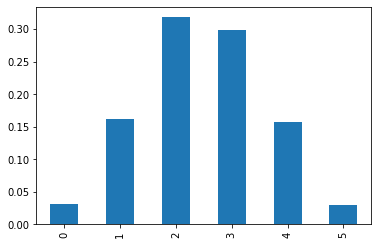

In [26]:
pd.Series(relative_counts).plot(kind='bar')

The outcomes, heads, are counts which are binomially distributed with the same probability in each toss. 

We can obtain these numbers more easily using the `binom` function. The line below computes the probability of seeing three heads in five trials when flipping an unbiased coin (p=0.5)

In [31]:
binom(n=5,p=.5).pmf(3)

0.3125

We can repeat this for each outcome to plot the binomial distribution.

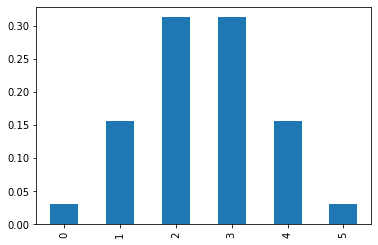

In [32]:
pd.Series(binom(n=5,p=.5).pmf([0,1,2,3,4,5])).plot(kind='bar')

## Intepreting coefficients

Remember that for OLS regression we simply model $y$ as a linear combination of other intercepts and slope (or an extension thereof). This facilitated the interpretation of the model because the units, and relation between predictor and response variables, were easy to interpret.

In a binomial regression, this is different. If we assume y arises from repeated trials, we can model how $p$ varies in function of other variables. In other words, model how "the probability of a success is related to explanatory variables" ([Wikipedia](https://en.wikipedia.org/wiki/Binomial_regression)).

$p$ however is a probability and always has to be between 0 and 1 (by definition). We can not model it as a simple linear function, because  a line function does not adhere to these constraints.

In other words, we can not say $y = a + b*x$ because $y$ can (and will) easily be negative or bigger than one.

To relate the probability $p_i$ to a linear function we have to do a small trick. We map the linear function to the logit($p_i$) = log($p$ / 1 - $p$) which can take any value for 0 < p < 1 (if p is close to zero the logit will converge to minus infinity). More about the `logit` function [here](https://en.wikipedia.org/wiki/Logit). The logit, in this scenario, is called the **link function**.

$y$ ~ Binomial($N$, $p_i$) 

logit($p_i$) = $a$ + $b$*$x_i$

logit($p_i$) = log($p_i$ / (1 - $p_i$)) = $a$ + $b$*$x_i$


To obtain $p_i$ we need to exponentiate (more detail below).


$p_i$ = $exp(a + b*x_i) / 1 + exp(a + b*x_i)$

### Gender bias in university admissions?

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit as logistic
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Let's now apply a binomial regression to a realistic and controversial case study: gender bias in university applications. The data we use records, for each gender, how often different departments admit (or rejects) application. For example: the first row states that for department A 512 male applications were admitted.

In [36]:
data = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/UCBadmit.csv',sep=';')
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


We need to slightly change the column names (because otherwise the StatsModels syntax gets confused later on).

In [38]:
data = data.rename({'applicant.gender':'gender'},axis=1)

Let's have a quick look at these data by computing the probability of admission for female and male applicants. This is easy in `pandas` for each gender we sum the admissions and total numbers of applications.

In [41]:
by_gender = data.groupby('gender')['admit','applications'].sum()
by_gender

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,admit,applications
gender,,
female,557,1835
male,1198,2691


Then we divide the admission by the total number of applications, which shows a huge gender gap: male applications are way more likely to be admitted. Now, why is this? A binomial regression will help us with determining the mechanisms at play here.

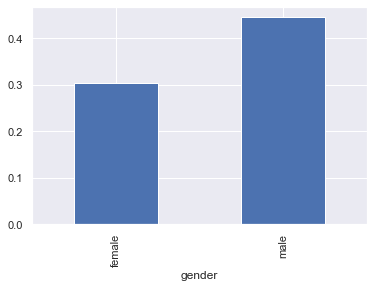

In [42]:
(by_gender['admit'] / by_gender['applications']).plot(kind='bar')

We start with a simple model, which uses gender as the only independent variable. 


Gender and departments are both categorical variables. To ensure that our model will read these variables correctly, we have to convert them. We use `did` as department codes and `gid` as gender codes.

In [48]:
data['gid'] = pd.Categorical(data['gender']).codes 
data['did'] = pd.Categorical(data['dept']).codes 
data.head()

,dept,gender,admit,reject,applications,gid,did
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2


Now we can feed these data to our model. We use a simple formula that estimates the effect of gender (right of the tilde sign) on the outcome (either admission or rejection, left of the tilde sign). We then pass the formula and data as arguments. Lastly, we apply the `.fit()` method, which means that we try find the parameters that are most consistent with, or 'fit', the data.

In [49]:
formula = 'admit +  reject ~ C(gid)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                       10
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -426.27
Date:                 Fri, 25 Mar 2022   Deviance:                       783.61
Time:                         13:13:42   Pearson chi2:                     715.
No. Iterations:                      4                                         
Covariance Type:             nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8305      0.051    -16

The summary is elaborate but we will focus on only a small part of the report: the coefficients, or how to interpret them? 

The most important part of the above output is `C(gid)[T.1]`, which gives us the effect of admission when moving from female (T.0) to male (T.1). The effect is positive and significant, but what does it mean?

The best way to make sense of these numbers is to understand how they model the outcome of success (probability of admission for each gender). We can calculate the probability of success by gender using the formulas we quickly touched upon earlier on in this notebook.

Please remember that we used `logit` function to map probability onto a linear function.

logit($p_i$) = $a$ + $b$*$x_i$

And to obtain the probability we need to apply:

$p_i$ = $exp(a + b*x_i) / 1 + exp(a + b*x_i)$

$a$ and $b$ are the parameters and $x_i$ the gender code. We can compute this by hand.

In [58]:
p_0 = np.exp(-0.8305 + 0.6104 * 0) / (1 + np.exp(-0.8305 + 0.6104 * 0) )
p_1 = np.exp(-0.8305 + 0.6104 * 1) / (1 + np.exp(-0.8305 + 0.6104 * 1) )

... and now we can obtain the probability of admission for female and male applicants. The findings of this model are in line with what we observed earlier: female applicants have a lower probability of being admitted (ca 0.14)

In [59]:
p_0,p_1

(0.3035393581861365, 0.44519606510456927)

In [60]:
p_1 - p_0 

0.1416567069184328

Of course, you can simply use the `logistic` function to obtain this result.

In [63]:
logistic(-0.8305 + 0.6104*1) - logistic(-0.8305 + 0.6104*0)

0.1416567069184328

The question is: how well does this model work? We can plot the predicted probability of admission (blue) against the observed probability (orange), which shows that the predictions are very bad. Clearly, the model is missing important information.

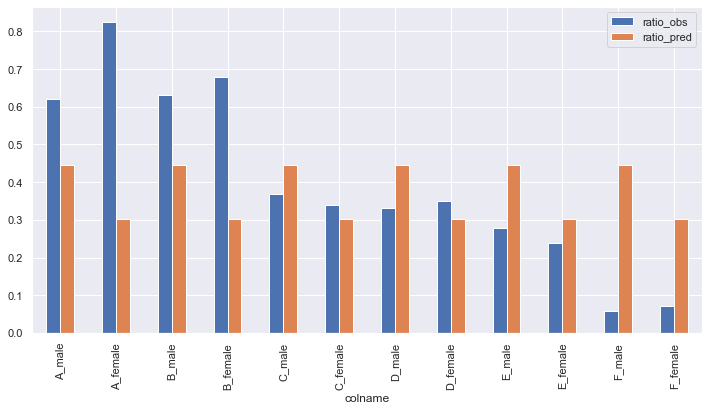

In [71]:
data['colname'] = data.apply(lambda x: x.dept + '_' + x.gender, axis=1)
data.set_index('colname',inplace=True)
data['ratio_obs'] = (data['admit'] / data['applications'])
data['ratio_pred'] = mod1.predict()
data[['ratio_obs','ratio_pred']].plot(kind='bar',figsize=(12,6),rot=90)

In crucia; element in the story is the variation by department visualised below.

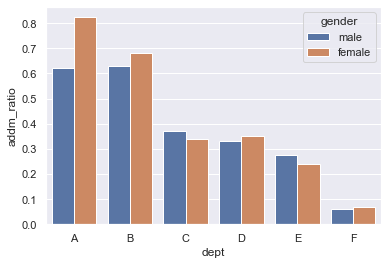

In [72]:
data['addm_ratio'] = data['admit'] / data['applications'] 
sns.barplot(x='dept',y='addm_ratio', hue="gender", data= data)

We can include the departments as another variable in our model.

In [70]:
formula = 'admit +  reject ~ C(gid) + C(did)'
mod3 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod3.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Fri, 25 Mar 2022   Deviance:                       20.204
Time:                         13:29:41   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6819      0.099      6

Interestingly, the previously positive effect for gender (indicating a bias towards male applicants) has disappeared. `C(gid)[T.1]` is now slightly negative, and not significant (the p-value of 0.217 is above the traditional 0.05 threshold). 

But how to align this finding with our previous result indicating that, overall, female application having substantial lower probability of getting accepted? Of course, this result holds. However, the reasons for the difference in admission rates doesn't seem to be a gender, but more of a institutional bias. Female applicants tend to apply more for departments which are more likely to reject applications. In other words, the model suggest the selection process seems fair, but the institution as a whole is not. The university which produced these data should create more places in specific departments, not changes the a

## Gender and parliamentary questions

In [73]:
df = pd.read_csv('data/questions/parl_questions.csv',index_col=0,
                 parse_dates=["dob",'date tabled'],
                date_parser= lambda x: pd.to_datetime(x, format="%Y-%m-%"))

In [75]:
df.party.unique()

array(['Conservative', 'Labour', 'Plaid Cymru', 'Labour (Co-op)',
       'Scottish National Party', 'Liberal Democrat', 'Independent',
       'Democratic Unionist Party', 'Green Party', nan,
       'The Independent Group for Change', 'Ulster Unionist Party',
       'Social Democratic & Labour Party', 'Alliance',
       'UK Independence Party'], dtype=object)

In [76]:
df = df[df.party.isin(['Conservative', 'Labour'])]

In [77]:
import re
pattern = re.compile(r'\bwoman\b|\bwomen\b|\bmother\b|\bmothers\b')
pattern.findall('woman bwomeno women. mothers.')

['woman', 'women', 'mothers']

In [78]:

df['about_woman'] = df['question text'].apply(lambda x: int(bool(pattern.findall(str(x).lower()))))

In [79]:
df['about_woman'].value_counts()

0    27807
1      396
Name: about_woman, dtype: int64

In [80]:
df[['gender_Female','gender_Male','party_Conservative','party_Labour']] =pd.get_dummies(df[['gender','party']])

In [81]:
formula = 'about_woman ~ gender_Female + party_Conservative'
mod1 = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                28203
Model:                            GLM   Df Residuals:                    28200
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2043.0
Date:                Fri, 25 Mar 2022   Deviance:                       4085.9
Time:                        13:34:24   Pearson chi2:                 2.82e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.6601      0

In [82]:
df_agg = df.groupby(['uri_mp','gender_Female','party_Conservative']).agg({'about_woman':'sum','uri':'count'}).reset_index()

In [83]:
df_agg['not_about'] = df_agg['uri'] - df_agg['about_woman']

In [84]:
formula = 'about_woman +  not_about ~ gender_Female + party_Conservative'
mod3 = smf.glm(formula=formula, data=df_agg, family=sm.families.Binomial()).fit()
print(mod3.summary())

                      Generalized Linear Model Regression Results                       
Dep. Variable:     ['about_woman', 'not_about']   No. Observations:                  527
Model:                                      GLM   Df Residuals:                      524
Model Family:                          Binomial   Df Model:                            2
Link Function:                            logit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -494.72
Date:                          Fri, 25 Mar 2022   Deviance:                       533.40
Time:                                  13:34:26   Pearson chi2:                     518.
No. Iterations:                               8                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

In [85]:
formula = 'about_woman ~ gender_Female + party_Conservative'
mod3 = smf.glm(formula=formula, data=df_agg, family=sm.families.Poisson()).fit()
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                  527
Model:                            GLM   Df Residuals:                      524
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -704.26
Date:                Fri, 25 Mar 2022   Deviance:                       946.54
Time:                        13:34:27   Pearson chi2:                 1.32e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.6926      0

In [86]:
logistic(0.9337) - logistic(0)

0.2178253320016068

In [87]:
df['answering_body_code'] = pd.Categorical(df['answering body']).codes

In [88]:
formula = 'about_woman ~ gender_Female + party_Conservative + C(answering_body_code)'
mod1 = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                28203
Model:                            GLM   Df Residuals:                    28159
Model Family:                Binomial   Df Model:                           43
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1353.9
Date:                Fri, 25 Mar 2022   Deviance:                       2707.8
Time:                        13:34:30   Pearson chi2:                 1.90e+04
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       